In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

df = pd.read_csv('data/CreditcardDefaults.csv')
df.rename(columns={'default payment next month':'default'}, inplace=True)

#set index to the "ID" value and remove the ID column
df.index = df.ID
del df['ID']

#Create Lists for Analysis
continuous_features = ['LIMIT_BAL', 'BILL_AMT1', 'BILL_AMT2','BILL_AMT3',
                       'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
                       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5',
                       'PAY_AMT6']
ordinal_features = ['EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0','PAY_2', 'PAY_3',
                    'PAY_4', 'PAY_5', 'PAY_6','default']

#Convert datatypes
df[continuous_features] = df[continuous_features].astype(np.float64)
df[ordinal_features] = df[ordinal_features].astype(np.int64)

#convert any non-identified education categories to 'OTHER'
df['EDUCATION'] = df['EDUCATION'].replace(to_replace=(0,5,6),value=4)

#convert any non-identified marriage categories to 'OTHER'
df['MARRIAGE'] = df['MARRIAGE'].replace(to_replace=(0),value=3)

#Log transform continuous variables; as they each have a mostly 
##exponential distribution
df["log_LIMIT_BAL"]=np.log(df.LIMIT_BAL)
df["log_PAY_AMT1"]=np.log(df.PAY_AMT1+1)
df["log_PAY_AMT2"]=np.log(df.PAY_AMT2+1)
df["log_PAY_AMT3"]=np.log(df.PAY_AMT3+1)
df["log_PAY_AMT4"]=np.log(df.PAY_AMT4+1)
df["log_PAY_AMT5"]=np.log(df.PAY_AMT5+1)
df["log_PAY_AMT6"]=np.log(df.PAY_AMT6+1)

# Creating a variable that counts how many times a client was two or more months late in making a payment
# Charts showing relationship of this variable to Default is in the Appendix.
#--------------------------------------------------------------------------------------------------------
# First set up new variables.  These will act as counters for each month's payment if the payment was more than one month late.
df['Del2Plus_0']=0 # Variable naming convention is "Delinquent 1 month in Month 0"
df['Del2Plus_2']=0 # Month 2
df['Del2Plus_3']=0 # etc ...
df['Del2Plus_4']=0
df['Del2Plus_5']=0
df['Del2Plus_6']=0

# set the values to 1 if payment was more month late.
df.loc[df['PAY_0'] >=2, 'Del2Plus_0'] = 1
df.loc[df['PAY_2'] >=2, 'Del2Plus_2'] = 1
df.loc[df['PAY_3'] >=2, 'Del2Plus_3'] = 1
df.loc[df['PAY_4'] >=2, 'Del2Plus_4'] = 1
df.loc[df['PAY_5'] >=2, 'Del2Plus_5'] = 1
df.loc[df['PAY_6'] >=2, 'Del2Plus_6'] = 1

# Add up the times payments were more than one month late.
df['Times2Plus']=df.Del2Plus_0+df.Del2Plus_2+df.Del2Plus_3+df.Del2Plus_4+df.Del2Plus_5+df.Del2Plus_6
#-----------------------------------------------------------------------------------------------------

# Creating an Attribute for % of billed Amounts Paid.  Cards not used have a rate of 1000
# Charts showing relationship of this variable to Default is in the Appendix.
df['TotalBilled'] = df.BILL_AMT1+df.BILL_AMT2+df.BILL_AMT3+df.BILL_AMT4+df.BILL_AMT5+df.BILL_AMT5
df['TotalPaid'] = df.PAY_AMT1+df.PAY_AMT2+df.PAY_AMT3+df.PAY_AMT4+df.PAY_AMT5+df.BILL_AMT5

df['PayRateCalc']  =  df['TotalPaid']/df['TotalBilled']
df['PayRateLimit'] = 0
df['PayRate'] = df['PayRateCalc'].where(df['PayRateCalc'] < 1.25, 1.25)
df['PayRate'] = df['PayRate'].where(df['TotalBilled'] > 0, 1000) # Approximately isolates Cards not used.
df['PayRate'] = df['PayRate'].where(df['PayRate'] > 0, 0)

df['PayrateGroup'] = df['PayRate']*100//5*5

# One-hot encoding of "EDUCATION", "MARRIAGE" and "PAY RATE".
tmp_df_1 = pd.get_dummies(df.EDUCATION,prefix='EDUCATION')
tmp_df_2 = pd.get_dummies(df.MARRIAGE,prefix='MARRIAGE')
tmp_df_3 = pd.get_dummies(df.PayrateGroup,prefix='PayRate')
tmp_df_4 = pd.get_dummies(df.Times2Plus,prefix='Times2Plus')
df = pd.concat((df,tmp_df_1,tmp_df_2,tmp_df_3,tmp_df_4),axis=1)
df2 =  pd.concat((df.default,tmp_df_1,tmp_df_2,tmp_df_3,tmp_df_4),axis=1)

# Setting up CV and Scaling

##  What's the difference between this and Stratified KFold?

In [5]:
from sklearn.model_selection import ShuffleSplit

# we want to predict the X and y data as follows:
if 'default' in df2:
    y = df2['default'].values # get the labels we want
    del df2['default'] # get rid of the class label
    X = df2.values # use everything else to predict!

    ## X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    #    have converted them into simple matrices to use with scikit learn
    
    
# CV and Test/Training Splits
num_cv_iterations = 5
cv_object = ShuffleSplit(n_splits=num_cv_iterations, random_state=0,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(n_splits=5, random_state=0, test_size=0.2, train_size=None)


In [6]:
from sklearn.preprocessing import StandardScaler

scl_obj = StandardScaler()

for train_indices, test_indices in cv_object.split(X,y): 
    
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
scl_obj.fit(X_train)

X_train_scaled = scl_obj.transform(X_train)
X_test_scaled = scl_obj.transform(X_test)

C:\Users\X\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


#### Visualizations

In [18]:
def per_class_accuracy(ytrue,yhat):
    conf = mt.confusion_matrix(ytrue,yhat)
    norm_conf = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis]
    return np.diag(norm_conf)

def plot_class_acc(ytrue,yhat, title=''):
    acc_list = per_class_accuracy(ytrue,yhat)
    plt.bar(range(len(acc_list)), acc_list)
    plt.xlabel('Not Default and Default')
    plt.ylabel('Accuracy within class')
    plt.title(title+", Total Acc=%.1f"%(100*mt.accuracy_score(ytrue,yhat)))
    plt.grid()
    plt.show()

# Predicting Default Rate

KNN accuracy 0.7226666666666667
Confusion matrix:
[[3857  785]
 [ 879  479]]
f1_score: 0.36536994660564465
Precision: 0.37895569620253167
Recall: 0.35272459499263625


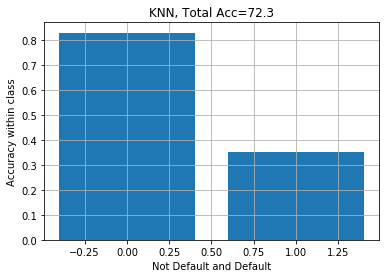

Wall time: 20.2 s


In [31]:
%%time

# )1 KNN 

from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics as mt

# The Classifier
clf = KNeighborsClassifier(n_neighbors=3)

for train, test in cv_object.split(X,y):
    clf.fit(X[train],y[train])
    yhat = clf.predict(X[test])

total_accuracy = mt.accuracy_score(y_test, yhat)
print ('KNN accuracy', total_accuracy)
conf = mt.confusion_matrix(y_test,yhat)
print('Confusion matrix:')
print(conf)
print('f1_score:', mt.f1_score(y_test, yhat))
print('Precision:', mt.precision_score(y_test, yhat))
print('Recall:', mt.recall_score(y_test, yhat))  
plot_class_acc(y_test,yhat,title="KNN")

In [33]:
Neighbors = [1,3,5,7,9,11]

for n in Neighbors:
    clf = KNeighborsClassifier(n_neighbors=n)

    for train, test in cv_object.split(X,y):
        clf.fit(X[train],y[train])
        yhat = clf.predict(X[test])
        
    print('-----Number of Neighbors: ', n)
    print ('KNN accuracy', mt.accuracy_score(y_test, yhat))
    print('f1_score:', mt.f1_score(y_test, yhat))
    print('Precision:', mt.precision_score(y_test, yhat))
    print('Recall:', mt.recall_score(y_test, yhat))  
        
        



-----Number of Neighbors:  1
KNN accuracy 0.7226666666666667
f1_score: 0.36536994660564465
Precision: 0.37895569620253167
Recall: 0.35272459499263625
-----Number of Neighbors:  3
KNN accuracy 0.7563333333333333
f1_score: 0.3687392055267703
Precision: 0.44572025052192066
Recall: 0.31443298969072164
-----Number of Neighbors:  5
KNN accuracy 0.788
f1_score: 0.39715639810426545
Precision: 0.5571808510638298
Recall: 0.3085419734904271
-----Number of Neighbors:  7
KNN accuracy 0.7911666666666667
f1_score: 0.3984637542006721
Precision: 0.5724137931034483
Recall: 0.30559646539027985
-----Number of Neighbors:  9
KNN accuracy 0.8003333333333333
f1_score: 0.39311043566362713
Precision: 0.6298701298701299
Recall: 0.2857142857142857
-----Number of Neighbors:  11
KNN accuracy 0.8001666666666667
f1_score: 0.4043715846994535
Precision: 0.6213740458015267
Recall: 0.29970544918998526


# Appendix

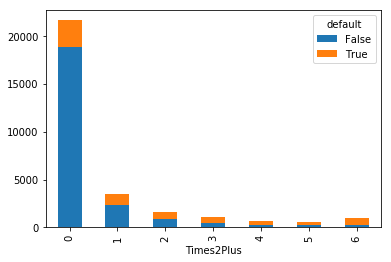

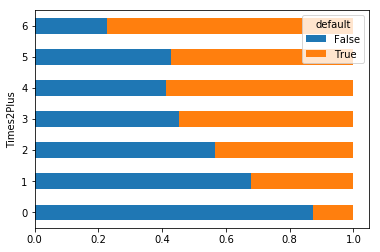

In [25]:
#  Default Rates increase with the number of times clients are 2 or more months late on their payments.
%matplotlib inline

Counts = pd.crosstab(df['Times2Plus'],df.default.astype(bool))
Counts.plot(kind='bar', stacked=True)#, ax=axes[fi,0])
    
Rate = Counts.div(Counts.sum(1).astype(float),axis=0)
Rate.plot(kind='barh', stacked=True)#, ax=axes[fi,1])
    
plt.show()

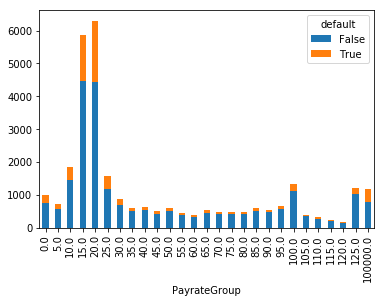

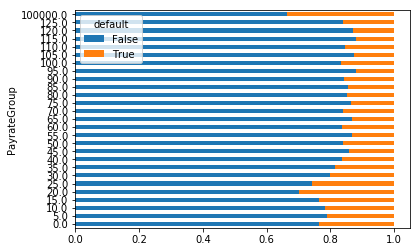

In [26]:
# Default Rates Increase with low payments as % of billed amounts.

Counts = pd.crosstab(df['PayrateGroup'],df.default.astype(bool))
Counts.plot(kind='bar', stacked=True)#, ax=axes[0,0])
    
Rate = Counts.div(Counts.sum(1).astype(float),axis=0)
Rate.plot(kind='barh', stacked=True)#, ax=axes[0,1])
    
plt.show()


# GARBAGE

In [ ]:
# Creating an Attribute for whether or not card was ever used.
# Charts showing relationship of this variable to Default is in the Appendix.
# Not used if Maximum Billed amount <=0.
df['MaxBilledAmount']=df[['BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6']].max(axis=1)
df['Usage'] = 1
df['Usage'] = df['Usage'].where(df['MaxBilledAmount'] > 0, 0)

#  Default Rates increase if clients don't use their cards.
%matplotlib inline

Counts = pd.crosstab(df['Usage'],df.default.astype(bool))
Counts.plot(kind='bar', stacked=True)#, ax=axes[fi,0])
    
Rate = Counts.div(Counts.sum(1).astype(float),axis=0)
Rate.plot(kind='barh', stacked=True)#, ax=axes[fi,1])
    
plt.show()